Import the necessary packages

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence, pad_packed_sequence
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import os
from itertools import groupby
import re


Preprocess the data: We define a target length, that all our sequences should have. We choose something in the range of 7-12 since alpha helices and beta sheets often have that many residues. 

We get rid of non-standard-aa sequences,we one-hot-encode the amino acid sequences and split the data according to the labels and then only take sequences of the target length

In [13]:


class Preprocessing:
    def __init__(self, target_length, secondary_type = 'sst3'):
        self.amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
        self.mapping_sst3 = {'C': 0, 'H': 1, 'E': 2}
        self.mapping_sst8 = {'C': 0, 'H': 1, 'E': 2, 'B': 3, 'G': 4, 'I':5, 'T':6, 'S':7}
        self.target_length = target_length
        self.secondary_type = secondary_type
        self.sequences = None
        self.labels = None
        self.lengths = None

    def one_hot_encode(self, sequence):
        # Create a tensor for the sequence where each amino acid is replaced by its index
        indices = torch.tensor([self.amino_acids.index(aa) for aa in sequence], dtype=torch.long)
        # One-hot encode
        return torch.nn.functional.one_hot(indices, num_classes=len(self.amino_acids)).type(torch.float)

    def process_labels(self, label):
        # Convert labels to indices
        if self.secondary_type == 'sst3':
            return torch.tensor([self.mapping_sst3[char] for char in label], dtype=torch.long)
        elif self.secondary_type == 'sst8':
            return torch.tensor([self.mapping_sst8[char] for char in label])
    
    def parser(self,labels, sequences):

        #when no key is provided to the groupby function, the labels itself are the key, "_" is representing the key and g is the list consisting of the same character
        categories = [''.join(g) for _, g in groupby(labels)]

        #perform those splits on the sequences
        splits = []
        corresponding_labels = []
        start = 0
        if categories:
            for category in categories:
                length = len(category)
                split = sequences[start:start+length]
                if len(split) == self.target_length:
                    splits.append(split)
                    corresponding_labels.append(category[0]) #only return the first label value
                    break #troubleshooting, to make sure that only one sequence is taken per string, otherwise there will be a mismatch (to be fixed)
    
                start += length
        
    
        return splits, corresponding_labels


    def preprocess_data(self, filepath, num_sequences=None):
        data = pd.read_csv(filepath)
        filtered_data = data[data['has_nonstd_aa'] == False]

        if num_sequences:
            filtered_data = filtered_data.sample(n = num_sequences)
            #filtered_data = filtered_data[:num_sequences]

        # Initialize lists for sequences and labels
        labels = []
        sequences = []
        for index1, lbl in enumerate(filtered_data[self.secondary_type]):
            for index2, seq in enumerate(filtered_data['seq']):
                if index1 == index2:
                    sequence, label = self.parser(lbl, seq)
                    if sequence:  # Check if split is not empty
                        sequences.extend(sequence)  # Append split to sequences list
                        labels.append(label[0]) #one label per sequence
        # print(labels)
        # print(len(sequences), len(labels))
        sequence_tensors = [self.one_hot_encode(seq) for seq in sequences]
        sequence_tensors = torch.stack(sequence_tensors).squeeze(0)
        label_tensors = self.process_labels(labels)



        #not necessary anymore at the moment
        # Padding sequences and labels
        # seq_lengths = torch.tensor([len(seq) for seq in sequence_tensors])
        # seq_tensor = torch.nn.utils.rnn.pad_sequence(sequence_tensors, batch_first=True, padding_value=0)
        # label_tensor = torch.nn.utils.rnn.pad_sequence(label_tensors, batch_first=True, padding_value=-1)  # Use -1 for label padding

        # Sort by sequence length in descending order for pack_padded_sequence
        #lengths, perm_idx = seq_lengths.sort(0, descending=True)
        #seq_tensor = seq_tensor[perm_idx]
        #label_tensor = label_tensor[perm_idx]


        self.sequences = sequence_tensors
        self.labels = label_tensors
        #self.lengths = lengths
        
        
        return sequence_tensors, label_tensors
    


Now we run our preprocessing, at initialization we choose a target length. At the preprocessing step, we choose how many sequences in our dataset we want to process (because of time reasons)

In [15]:
#set num_sequences to False if you want all of them

secondary_output_number = 3 #chanege this together with secondary_type 

preprocessor = Preprocessing(target_length= 7, secondary_type = 'sst3')
path = '/Users/mcopet/Library/Mobile Documents/com~apple~CloudDocs/University/ETH/Semester2/CompBio/Project/2018-06-06-ss.cleaned.csv'
sequence_tensors, label_tensors = preprocessor.preprocess_data(path, num_sequences= 40000)

print(sequence_tensors. shape)
print(label_tensors.shape) #correct shapes


torch.Size([32102, 7, 20])
torch.Size([32102])


We define our model and our dataset. As model we choose a LSTM.

In [16]:

class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        output, (hn, cn) = self.lstm(x)
        out = self.fc(output[:, -1, :])  # Take the last output of the LSTM sequence
        return out

class AminoAcidDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences 
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]


We split our dataset into training, validation and test.

In [17]:
total = len(sequence_tensors)
train_size = int(0.6 * total)  # 60% of data for training
val_size = int(0.2 * total)    # 20% of data for validation
test_size = total - train_size - val_size  # Remaining 20% of data for testing

indices = torch.randperm(total).tolist()

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

train_sequences = sequence_tensors[train_indices]
train_labels = label_tensors[train_indices]

val_sequences = sequence_tensors[val_indices]
val_labels = label_tensors[val_indices]

test_sequences = sequence_tensors[test_indices]
test_labels = label_tensors[test_indices]


In [18]:

#lengths = torch.tensor([len(seq) for seq in sequence_tensors])
dataset = AminoAcidDataset(sequence_tensors, label_tensors)
loader = DataLoader(dataset, batch_size = 1000, shuffle = False)
train_dataset = AminoAcidDataset(train_sequences,train_labels)
val_dataset = AminoAcidDataset(val_sequences, val_labels)
test_dataset = AminoAcidDataset(test_sequences, test_labels)
trainloader = DataLoader(train_dataset, batch_size = 100, shuffle = True)
valloader = DataLoader(val_dataset, batch_size = 100, shuffle = True)
testloader = DataLoader(test_dataset, batch_size = 100)
#pack_padded_sequence(padded_sequences,...)



Define the model, loss function and optimizer. We use Adam optimizer and the crossentropy loss for multiclass classification

In [19]:
#Define the model, secondary_type (for output dimension), loss function and optimizer
model = Model(input_dim = 20, hidden_dim =140 , layer_dim = 6, output_dim = secondary_output_number)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
#device = ("mps" if torch.backends.mps.is_available() else "cpu")
#model.to(device)


Training and validation step

In [20]:

# Set the number of epochs
num_epochs = 200

# Initialize lists to monitor loss and accuracy
train_losses = []
val_losses = []
val_accuracies = []

# Iterate over epochs
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    total_correct = 0
    total_samples = 0
    
    # Training phase
    for sequences, labels in trainloader:
        optimizer.zero_grad()
        sequences = sequences.float()
        
        # Forward pass
        outputs = model(sequences)
        outputs_flat = outputs.view(-1, secondary_output_number)
        labels_flat = labels.view(-1)
        
        # Calculate loss
        loss = criterion(outputs_flat, labels_flat)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        epoch_loss += loss.item() * sequences.size(0)
        
        # Calculate total correct predictions
        _, predicted = torch.max(outputs_flat, 1)
        total_correct += (predicted == labels_flat).sum().item()
        total_samples += labels_flat.size(0)
    
    # Average loss for this epoch
    epoch_loss /= len(trainloader.dataset)
    train_losses.append(epoch_loss)

    # Calculate training accuracy
    train_accuracy = total_correct / total_samples
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for sequences, labels in valloader:
            sequences = sequences.float()
            outputs = model(sequences)
            outputs_flat = outputs.view(-1, secondary_output_number)
            labels_flat = labels.view(-1)
            
            # Calculate validation loss
            val_loss += criterion(outputs_flat, labels_flat).item() * sequences.size(0)
            
            # Calculate total correct predictions
            _, predicted = torch.max(outputs_flat, 1)
            val_correct += (predicted == labels_flat).sum().item()
            val_total += labels_flat.size(0)
    
    # Average validation loss for this epoch
    val_loss /= len(valloader.dataset)
    val_losses.append(val_loss)
    
    # Calculate validation accuracy
    val_accuracy = val_correct / val_total
    val_accuracies.append(val_accuracy)

    # Print progress
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')




Epoch [1/200], Training Loss: 1.0351, Training Accuracy: 0.4638, Validation Loss: 0.9525, Validation Accuracy: 0.4604
Epoch [2/200], Training Loss: 0.8096, Training Accuracy: 0.6618, Validation Loss: 0.6994, Validation Accuracy: 0.7084
Epoch [3/200], Training Loss: 0.6746, Training Accuracy: 0.7117, Validation Loss: 0.6677, Validation Accuracy: 0.7125
Epoch [4/200], Training Loss: 0.6500, Training Accuracy: 0.7250, Validation Loss: 0.6648, Validation Accuracy: 0.7201
Epoch [5/200], Training Loss: 0.6425, Training Accuracy: 0.7279, Validation Loss: 0.6538, Validation Accuracy: 0.7165
Epoch [6/200], Training Loss: 0.6325, Training Accuracy: 0.7328, Validation Loss: 0.6894, Validation Accuracy: 0.7087
Epoch [7/200], Training Loss: 0.6249, Training Accuracy: 0.7397, Validation Loss: 0.6430, Validation Accuracy: 0.7262
Epoch [8/200], Training Loss: 0.6163, Training Accuracy: 0.7426, Validation Loss: 0.6373, Validation Accuracy: 0.7308
Epoch [9/200], Training Loss: 0.6083, Training Accuracy:

KeyboardInterrupt: 

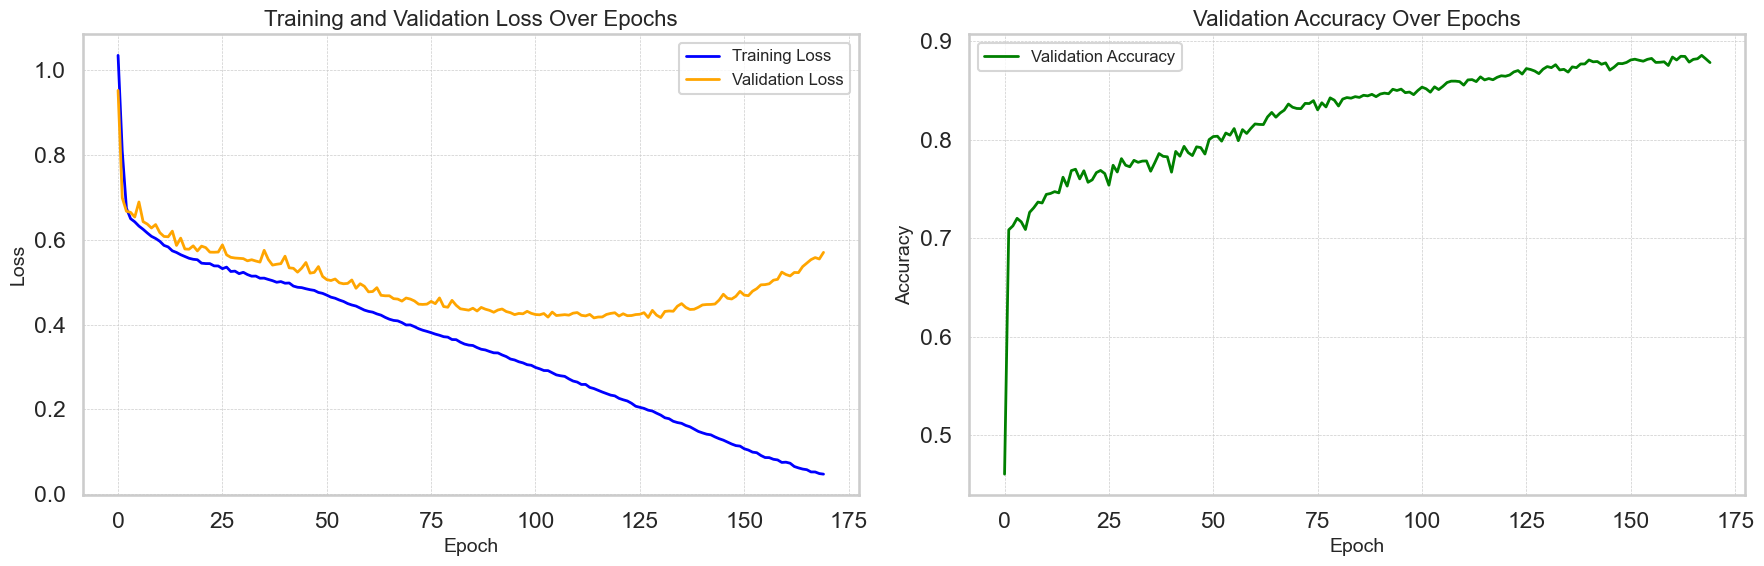

In [21]:
sns.set(style="whitegrid", context="talk")

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plotting the training loss and validation loss on the first subplot
sns.lineplot(x=range(len(train_losses)), y=train_losses, ax=ax1, label='Training Loss', color='blue', linewidth=2)
sns.lineplot(x=range(len(val_losses)), y=val_losses, ax=ax1, label='Validation Loss', color='orange', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.set_title('Training and Validation Loss Over Epochs', fontsize=16)
ax1.legend(fontsize=12)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plotting the validation accuracy on the second subplot
sns.lineplot(x=range(len(val_accuracies)), y=val_accuracies, ax=ax2, label='Validation Accuracy', color='green', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=14)
ax2.set_ylabel('Accuracy', fontsize=14)
ax2.set_title('Validation Accuracy Over Epochs', fontsize=16)
ax2.legend(fontsize=12)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust the layout for better spacing
plt.tight_layout()
plt.show()

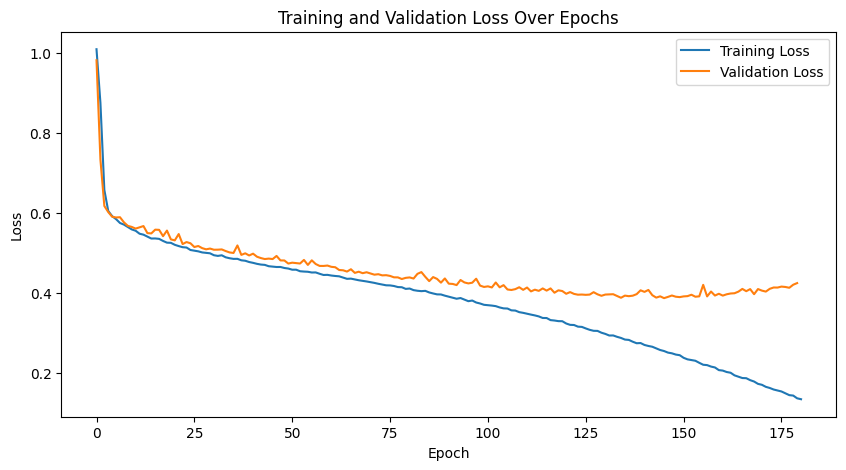

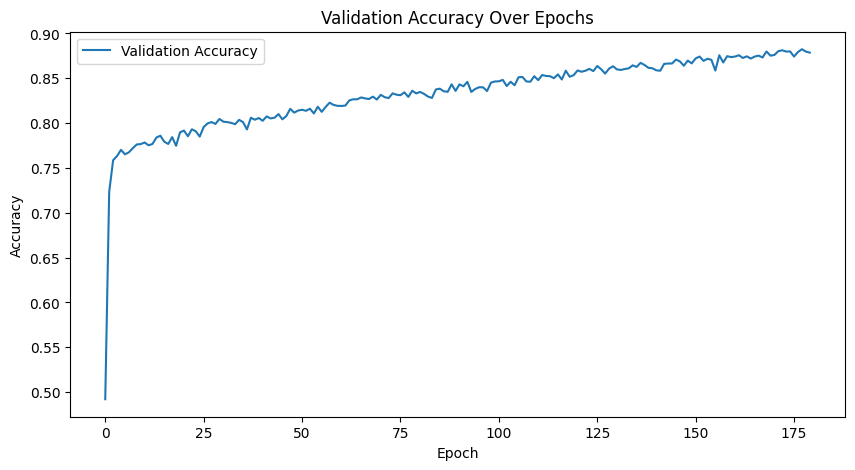

In [ ]:

# Plotting the training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Plotting the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

Now we evaluate on the Test-Set

In [22]:
model.eval()
test_loss = 0
test_correct = 0
test_total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for sequences, labels in testloader:
            outputs = model(sequences)
            outputs_flat = outputs.view(-1, 3)
            labels_flat = labels.view(-1)
                
            # Calculate validation loss
            test_loss += criterion(outputs_flat, labels_flat).item() * sequences.size(0)
            
            # Calculate total correct predictions
            _, predicted = torch.max(outputs_flat, 1)
            test_correct += (predicted == labels_flat).sum().item()
            test_total += labels_flat.size(0)

            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())

test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy}')
report = classification_report(all_labels, all_predictions, target_names=['C', 'H', 'E'])
print(report)

Test Accuracy: 0.8757202927892852
              precision    recall  f1-score   support

           C       0.90      0.90      0.90      2944
           H       0.81      0.79      0.80      1217
           E       0.88      0.88      0.88      2260

    accuracy                           0.88      6421
   macro avg       0.86      0.86      0.86      6421
weighted avg       0.88      0.88      0.88      6421



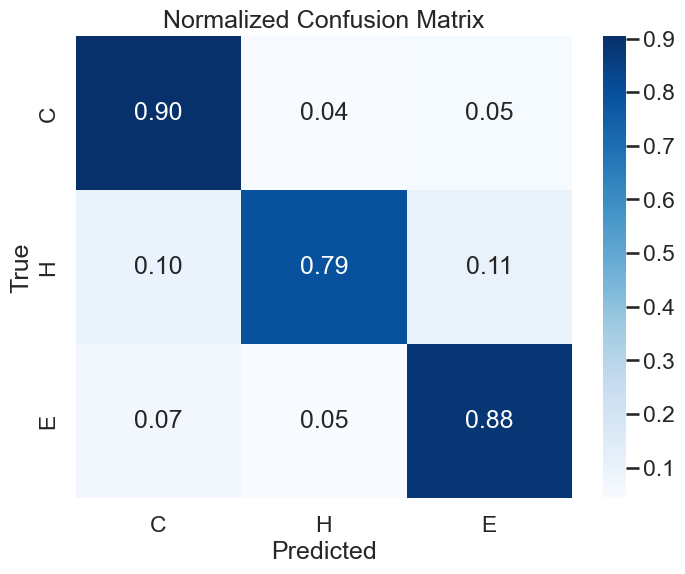

In [51]:
# Assuming all_true_labels and all_pred_labels are your true and predicted labels
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap="Blues", xticklabels=['C', 'H', 'E'], yticklabels=['C', 'H', 'E'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()


PART 2 OF THE PROJECT: Secondary structure prediction using Hidden Markov Models (HMM)

In [ ]:
from hmmlearn import hmm
from sklearn.model_selection import train_test_split


Preprocess data again, but this time converting to integers, rather than one-hot-encoding them. Also we convert to list instead of tensors.

In [30]:

class Preprocessing:
    def __init__(self, target_length, secondary_type='sst3'):
        self.amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
        self.mapping_sst3 = {'C': 0, 'H': 1, 'E': 2}
        self.mapping_sst8 = {'C': 0, 'H': 1, 'E': 2, 'B': 3, 'G': 4, 'I':5, 'T':6, 'S':7}
        self.target_length = target_length
        self.secondary_type = secondary_type
        self.sequences = None
        self.labels = None
        self.lengths = None

    def encode_sequence(self, sequence):
        # Convert the sequence to indices
        return np.array([self.amino_acids.index(aa) for aa in sequence], dtype=int)

    def process_labels(self, label):
        # Convert labels to indices
        if self.secondary_type == 'sst3':
            return np.array([self.mapping_sst3[char] for char in label])
        elif self.secondary_type == 'sst8':
            return np.array([self.mapping_sst8[char] for char in label])
    
    def parser(self, labels, sequences):
        # Group by consecutive labels
        categories = [''.join(g) for _, g in groupby(labels)]
        # Perform splits on the sequences
        splits = []
        corresponding_labels = []
        start = 0
        for category in categories:
            length = len(category)
            split = sequences[start:start+length]
            if len(split) == self.target_length:
                splits.append(split)
                corresponding_labels.append(category[0])
                break  # Ensure only one sequence per label
            start += length
        return splits, corresponding_labels

    def preprocess_data(self, filepath, num_sequences=None):

        data = pd.read_csv(filepath)
        filtered_data = data[data['has_nonstd_aa'] == False]

        if num_sequences:
           filtered_data = filtered_data.sample(n = num_sequences)
            #filtered_data = filtered_data.iloc[:num_sequences]

        labels = []
        sequences = []
        # Iterate over each sequence and corresponding label
        for lbl, seq in zip(filtered_data[self.secondary_type], filtered_data['seq']):
            sequence, label = self.parser(lbl, seq)
            if sequence:
                sequences.extend(sequence)
                labels.extend(label)  # Store labels, expecting a single label per sequence

        # Convert sequences to index arrays
        sequence_arrays = [self.encode_sequence(seq) for seq in sequences]
        label_arrays = self.process_labels(labels)  # Convert labels to index format
        self.sequences = sequence_arrays
        self.labels = label_arrays
        
        return sequence_arrays, label_arrays


Process data and split into train and test. Note that we only need our training labels to split the data into 3 separate lists

In [31]:
preprocessor = Preprocessing(target_length= 7, secondary_type = 'sst3')
path = '/Users/mcopet/Library/Mobile Documents/com~apple~CloudDocs/University/ETH/Semester2/CompBio/Project/2018-06-06-ss.cleaned.csv'
sequences, labels = preprocessor.preprocess_data(path, num_sequences= 50000)



Below, we further preprocess our data by splitting our data into 3 different lists according to our data. The lenghts are actually ignored and are only an artifact of previous code.

In [32]:

def converter(sequences, labels): 

    helix = []
    sheet = []
    other = []
    
    #append to the 3 different lists depending on the train label
    for index, sequence in enumerate(sequences):
        if labels[index] == 1:
            helix.append(sequence)
        elif labels[index] == 2:
            sheet.append(sequence)
        else: other.append(sequence)


    return helix, sheet, other, 



After having created our 3 lists, we are now implementing our actual baum-welch algorithm and our training and prediction phase. Refer to the PDF for further insights into the baum-welch algorithm

In [33]:
import numpy as np

class HMM:
    def __init__(self, num_states, num_symbols):
        self.num_states = num_states
        self.num_symbols = num_symbols
        self.epsilon = 1e-10  # Small constant to avoid log(0)

        self.transition_probs = np.random.rand(num_states, num_states) + self.epsilon
        self.emission_probs = np.random.rand(num_states, num_symbols) + self.epsilon
        self.initial_probs = np.random.rand(num_states) + self.epsilon

        # Normalize probabilities to ensure they sum to 1
        self.transition_probs /= self.transition_probs.sum(axis=1, keepdims=True)
        self.emission_probs /= self.emission_probs.sum(axis=1, keepdims=True)
        self.initial_probs /= self.initial_probs.sum()


    def forward_algorithm(self, seq):
        T = len(seq)

        alpha = np.zeros((T, self.num_states))
        
        # Initialize first column of alpha
        for i in range(self.num_states):
            alpha[0][i] = self.initial_probs[i] * self.emission_probs[i][seq[0]]
        
        # Recursion
        for t in range(1, T):
            for j in range(self.num_states):
                alpha[t][j] = np.sum(alpha[t-1] * self.transition_probs[:, j] * self.emission_probs[j][seq[t]])
        
        return alpha
    
    def backward_algorithm(self, seq):
        T = len(seq)
        beta = np.zeros((T, self.num_states))
        beta[T - 1] = 1

        for t in range(T-2, -1, -1):
            for i in range(self.num_states):
                beta[t][i] = np.sum(self.transition_probs[i] * self.emission_probs[:, seq[t+1]] * beta[t+1])
        
        return beta

    def expectation_step(self, seq):
        T = len(seq)
        alpha = self.forward_algorithm(seq)
        beta = self.backward_algorithm(seq)

        #print(f'alpha: {alpha}, beta: {beta}')

        # Calculate gamma
        gamma = alpha * beta
        gamma /= gamma.sum(axis=1, keepdims=True)  # Normalize
        
        # Calculate xi
        xi = np.zeros((T - 1, self.num_states, self.num_states))
        for t in range(T - 1):
            for i in range(self.num_states):
                for j in range(self.num_states):
                    xi[t][i][j] = alpha[t][i] * self.transition_probs[i][j] * self.emission_probs[j][seq[t+1]] * beta[t+1][j]
            xi[t] /= xi[t].sum()  # Normalize

        #print(f'xi: {xi}, gamma: {gamma}')
        
        return xi, gamma
    

    def normalize_parameters(self):
        # Normalize transition probabilities
        self.transition_probs /= self.transition_probs.sum(axis=1, keepdims=True)

        # Normalize emission probabilities
        self.emission_probs /= self.emission_probs.sum(axis=1, keepdims=True)

        # Normalize initial probabilities
        self.initial_probs /= self.initial_probs.sum()


    def train(self, sequences, num_iterations=1000):
        R = len(sequences)  # Number of sequences
        for _ in range(num_iterations):
            # Initialize matrices to accumulate updates for each parameter
            total_xi_probs = np.zeros_like(self.transition_probs)
            gamma_indicator_probs = np.zeros_like(self.emission_probs)
            total_gamma_probs = np.zeros((self.num_states, 1))
            total_initial_probs = np.zeros_like(self.initial_probs)

            for seq in sequences:
                ################ Expectation step
                xi, gamma = self.expectation_step(seq)
                #####################################


                # Accumulate updates for transition and initial probabilities
                total_xi_probs += xi.sum(axis=0)
                total_initial_probs += gamma[0]
                total_gamma_probs += gamma[:-1].sum(axis=0).reshape(-1, 1)  # Sum over all t-1 for each state

                # Accumulate updates for emission probabilities
                for t in range(len(seq)):
                    symbol = seq[t]
                    gamma_indicator_probs[:, symbol] += gamma[t]

            ##################### Maximization step #################


            # Transition probabilities
            self.transition_probs = total_xi_probs / total_gamma_probs

            # Emission probabilities
            self.emission_probs = gamma_indicator_probs / total_gamma_probs

            # Initial probabilities are simply averaged over all sequences
            self.initial_probs = total_initial_probs / R

            # Normalizing probabilities to ensure they sum to 1
            self.normalize_parameters()

            ############################################################


    def score(self, seq):
        alpha = self.forward_algorithm(seq)
        return alpha[-1].sum()
    
    # used for predicting the most probable state path
    def viterbi_algorithm(self, seq):
        T = len(seq)
        V = np.zeros((self.num_states, T))
        path = np.zeros((self.num_states, T), dtype=int)

        # Initialize base cases (t == 0)
        V[:, 0] = self.initial_probs * self.emission_probs[:, seq[0]]

        # Run Viterbi for t > 0
        for t in range(1, T):
            for j in range(self.num_states):
                seq_prob = self.emission_probs[j, seq[t]]
                (prob, state) = max((V[i, t-1] * self.transition_probs[i, j] * seq_prob, i) for i in range(self.num_states))
                V[j, t] = prob
                path[j, t] = state

        # The final most probable sequence and its probability
        n = 0  # the last time step
        (prob, state) = max((V[j, T-1], j) for j in range(self.num_states))
        sequence = np.zeros(T, dtype=int)
        sequence[T-1] = state

        # Follow the backtrack till the first observation
        for t in range(T-2, -1, -1):
            sequence[t] = path[sequence[t+1], t+1]

        return sequence, prob

    

This is the crucial part. The sequences are split into training and test and converted into 3 lists from our preprocessing above. 3 different HMMs are trained, one for each type of sequence (Helix, Sheet, other). The training is based on the Baum-Welch Algorithm. We then predict on the test sequences by getting the summed probabilites of each model, i.e. the probability that this test sequence belongs to that HMM and thus this label. The sequence gets assigned the label with the highest probability and is compared with the actual label. As metric the accuracy score is used

In [35]:
def predict(sequences, labels, n_iter=1000):
    training, testing, train_labels, test_labels = train_test_split(sequences, labels, test_size=0.2, random_state=1)

    # create 3 separate lists and concatenate the lists into one long sequence each
    helix, sheet, other = converter(training, train_labels)

    # create HMM models
    hmm_helix = HMM(3, 20)
    hmm_sheet = HMM(3, 20)
    hmm_other = HMM(3, 20)

    # fit the model for each sequence
    hmm_helix.train(helix, num_iterations=n_iter)
    hmm_sheet.train(sheet, num_iterations=n_iter)
    hmm_other.train(other, num_iterations=n_iter)

    models = [hmm_helix, hmm_sheet, hmm_other]
    prediction_labels = [1, 2, 0]  # since helix has label 1, sheet has 2, other has 0

    # initialise to compute accuracy
    total = len(testing)
    correct = 0

    all_true_labels = []
    all_pred_labels = []

    # calculate log likelihoods and take index of highest likelihood model
    for index, prediction in enumerate(testing):
        log_probs = [model.score(prediction) for model in models]
        best = np.argmax(log_probs)

        predicted_label = prediction_labels[best]
        true_label = test_labels[index]

        all_true_labels.append(true_label)
        all_pred_labels.append(predicted_label)

        # compute if predictions match
        if true_label == predicted_label:
            correct += 1

    accuracy = (correct / total) * 100
    print(f'Accuracy: {accuracy}')

    # Generate and print the classification report
    target_names = ['Other', 'Helix', 'Sheet']
    report = classification_report(all_true_labels, all_pred_labels, target_names=target_names)
    print(report)

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(all_true_labels, all_pred_labels)
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap="Blues", xticklabels=target_names, yticklabels=target_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Normalized Confusion Matrix")
    plt.show()


Method 1: predict based on the joint probability of observing the sequence

Accuracy: 75.67668704003991
              precision    recall  f1-score   support

       Other       0.89      0.78      0.83      3604
       Helix       0.55      0.72      0.62      1602
       Sheet       0.77      0.74      0.76      2811

    accuracy                           0.76      8017
   macro avg       0.73      0.75      0.74      8017
weighted avg       0.78      0.76      0.76      8017



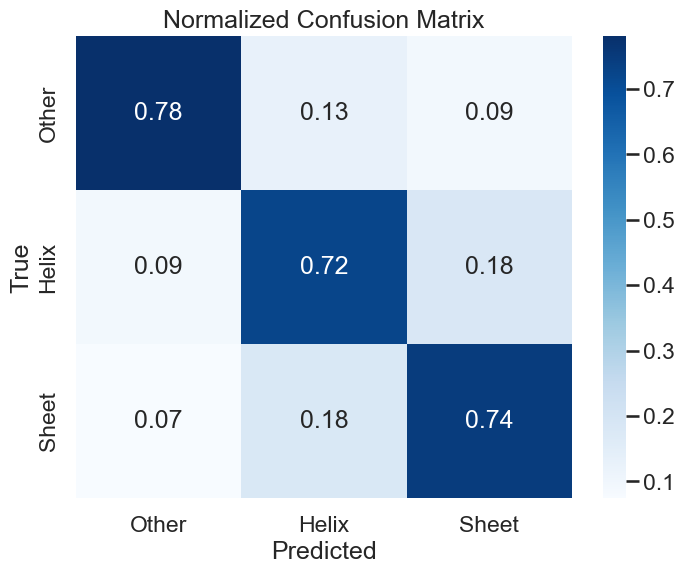

In [36]:
predict(sequences, labels, n_iter= 1000)

Method 2: Predict the whole sequence based on the most probable path, called the viterbi path, this is a fully unsupervised approach

In [ ]:
#train the model
hmm = HMM(3, 20)
training, testing, train_labels, test_labels = train_test_split(sequences, labels, test_size = 0.2, random_state= 1)
hmm.train(training, num_iterations= 50)

In [ ]:
correct = 0
total = len(testing)
for index,sequence in enumerate(testing):
    pred_states, pred_probs = hmm.viterbi_algorithm(sequence)
    prediction = max(set(pred_states), key=pred_states.tolist().count)
    if prediction == test_labels[index]:
        correct += 1
    #print(f'predicted states: {pred_states}, actual label: {test_labels[index]}, prediction: {prediction}')
print(f'Accuracy: {correct/total}')

Accuracy: 0.4256120527306968


In [ ]:
accuracy = []
for i in range(10):
    #train the model
    hmm = HMM(3, 20)
    training, testing, train_labels, test_labels = train_test_split(sequences, labels, test_size = 0.2, random_state= 1)
    hmm.train(training, num_iterations= 130)
    correct = 0
    total = len(testing)
    for index,sequence in enumerate(testing):
        pred_states, pred_probs = hmm.viterbi_algorithm(sequence)
        prediction = max(set(pred_states), key=pred_states.tolist().count)
        if prediction == test_labels[index]:
            correct += 1
        #print(f'predicted states: {pred_states}, actual label: {test_labels[index]}, prediction: {prediction}')
    accuracy.append(correct/total)
    print(f'Accuracy: {correct/total}')

print(f'average: {np.mean(accuracy)}')

Accuracy: 0.38695163104611924


KeyboardInterrupt: 

Using the library hmmlearn

In [49]:
from hmmlearn.hmm import GaussianHMM
import hmmlearn.hmm as hmm

def converter(training, train_labels):
    helix = []
    sheet = []
    other = []
    for i, label in enumerate(train_labels):
        if label == 1:
            helix.extend(training[i])
        elif label == 2:
            sheet.extend(training[i])
        else:
            other.extend(training[i])
    return helix, sheet, other

def predict(sequences, labels, n_iter=1000):
    training, testing, train_labels, test_labels = train_test_split(sequences, labels, test_size=0.2, random_state=1)

    # create 3 separate lists and concatenate the lists into one long sequence each
    helix, sheet, other = converter(training, train_labels)

    # create HMM models using hmmlearn
    hmm_helix = hmm.CategoricalHMM(n_components=3, n_iter=n_iter)
    hmm_sheet = hmm.CategoricalHMM(n_components=3, n_iter=n_iter)
    hmm_other = hmm.CategoricalHMM(n_components=3, n_iter=n_iter)

    # fit the model for each sequence
    hmm_helix.fit(np.array(helix).reshape(-1, 1))
    print('fitted')
    hmm_sheet.fit(np.array(sheet).reshape(-1, 1))
    hmm_other.fit(np.array(other).reshape(-1, 1))

    models = [hmm_helix, hmm_sheet, hmm_other]
    prediction_labels = [1, 2, 0]  # since helix has label 1, sheet has 2, other has 0

    # initialise to compute accuracy
    total = len(testing)
    correct = 0

    all_true_labels = []
    all_pred_labels = []

    # calculate log likelihoods and take index of highest likelihood model
    for index, prediction in enumerate(testing):
        log_probs = [model.score(np.array(prediction).reshape(-1, 1)) for model in models]
        best = np.argmax(log_probs)

        predicted_label = prediction_labels[best]
        true_label = test_labels[index]

        all_true_labels.append(true_label)
        all_pred_labels.append(predicted_label)

        # compute if predictions match
        if true_label == predicted_label:
            correct += 1

    accuracy = (correct / total) * 100
    print(f'Accuracy: {accuracy}')

    # Generate and print the classification report
    target_names = ['Other', 'Helix', 'Sheet']
    report = classification_report(all_true_labels, all_pred_labels, target_names=target_names)
    print(report)

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(all_true_labels, all_pred_labels)
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap="Blues", xticklabels=target_names, yticklabels=target_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Normalized Confusion Matrix")
    plt.show()


fitted
Accuracy: 65.27379318947237
              precision    recall  f1-score   support

       Other       0.84      0.69      0.76      3604
       Helix       0.40      0.61      0.48      1602
       Sheet       0.67      0.63      0.65      2811

    accuracy                           0.65      8017
   macro avg       0.64      0.64      0.63      8017
weighted avg       0.69      0.65      0.67      8017



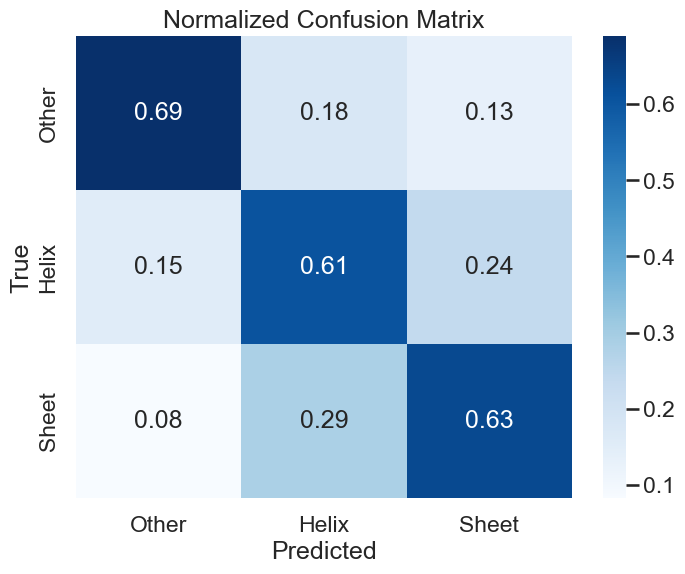

In [50]:
predict(sequences, labels, n_iter= 1000)

Way faster, but worse results